# Upward longwave radiation at the surface ($LW_u$)

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - \textcolor{red}{LW_u} - H - \lambda E - G       \tag{1.2}
$$

- **Definition**: The longwave radiation emitted from the land surface.

- **Equation**:

$$
LW_u = \epsilon_s \sigma T_s^4      \tag{5.1}
$$

where $\epsilon_s$ is the emissivity of the land surface, $\sigma$ is the Stefan-Boltzmann constant (5.67 $\times$ 10<sup>-8</sup> W/m<sup>2</sup>/K<sup>4</sup>)

<br>
<br>
<hr>

### Emissivity of the land surface ($\epsilon_s$)

Typically 0.90 ~ 0.99.

In [1]:
EMISSIVITY_S = 0.95

<br>
<br>
<hr>

### Stefan-Boltzmann constant ($\sigma$)

In [2]:
SB_CONSTANT = 5.67 * 1.0e-8 #W/m2/K4

<br>
<br>
<hr>

### Practice 5.1
Compute $LW_u$ for a given range of $T_s$ (250-310 K).

In [3]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

$$
LW_u = \epsilon_s \sigma T_s^4      \tag{5.1}
$$

In [4]:
# Define Ts range
Ts = np.arange(250.0, 310.0+1, 1)

# Calculate LWu
def calculate_LWu(Ts):
    LWu = EMISSIVITY_S * SB_CONSTANT * Ts**4
    return LWu

LWu_np = calculate_LWu(Ts)

# Put LWd into xarray
LWu = xr.Dataset(
                 {'LWu': (['Ts'], LWu_np)},
                 coords={'Ts': Ts},
                 attrs={'units': 'W/m2',
                         'long_name': 'Upward longwave radiation'},
)
LWu

<xarray.Dataset> Size: 976B
Dimensions:  (Ts: 61)
Coordinates:
  * Ts       (Ts) float64 488B 250.0 251.0 252.0 253.0 ... 308.0 309.0 310.0
Data variables:
    LWu      (Ts) float64 488B 210.4 213.8 217.2 220.7 ... 484.7 491.1 497.5
Attributes:
    units:      W/m2
    long_name:  Upward longwave radiation

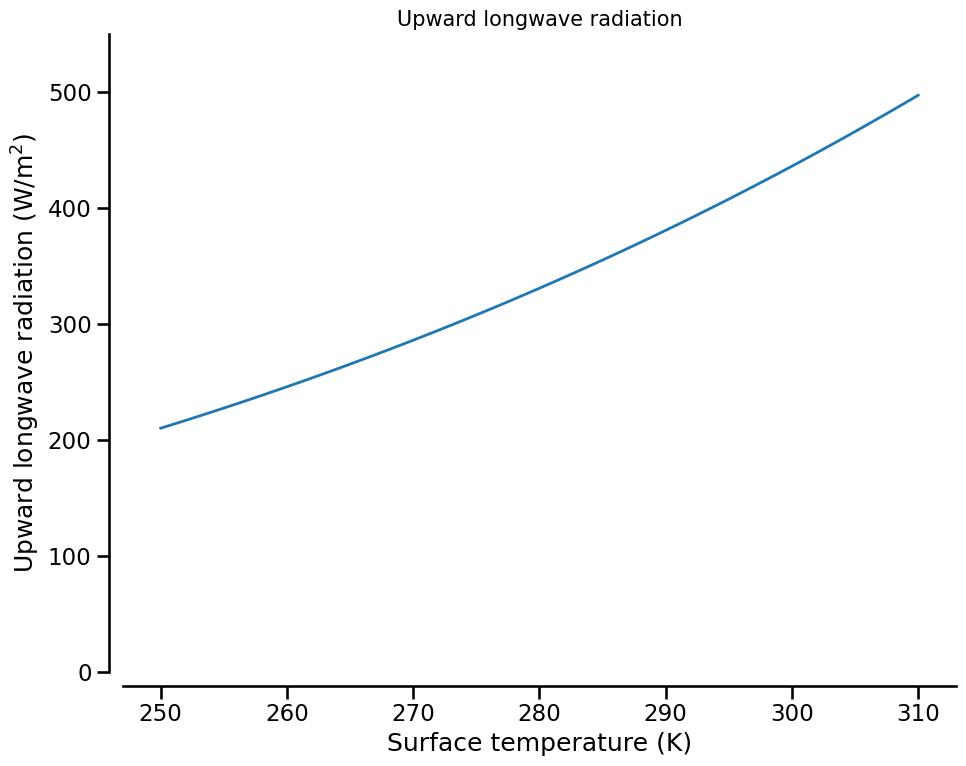

In [5]:
# plot

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(10, 8))

### plotting
ax.plot(Ts, LWu['LWu'], linewidth=2)

### properties
ax.set_title('Upward longwave radiation', fontsize=15)
ax.set_xlabel('Surface temperature (K)', fontsize=18)
ax.set_ylabel('Upward longwave radiation (W/m$^{2}$)', fontsize=18)
ax.set_ylim(0, 550)

sns.despine(offset=10)
plt.tight_layout()

<br>
<br>
<hr>

### Practice 5.2
Predict $T_s$ in 2025 at SNU Building 501. Assume that 
1) $T_s$ at initial time is 295 K
1) $C_{soil}$ is $c_{soil} \cdot d_s$, where $c_{soil}$ is heat capacity of soil (2.0 $\times$ 10<sup>6</sup> J/m<sup>3</sup>/K) and $d_s$ is depth of soil (0.07 m)
1) $\alpha$ is 0.3
1) $LW_d$ is 400 W/m<sup>2</sub>
1) $H$ and $\lambda E$ are 30% of $SW_d$
1) $G$ is 0 W/m<sup>2</sub>


&#8594; Predict $\textcolor{red}{T_s}$, $\textcolor{red}{LW_u}$ by prescribing $SW_d$, $LW_d$, $H$, $\lambda E$, $G$:

$$
C_{soil} \textcolor{red}{\frac{\partial T_{s}}{\partial t}} = (1-\alpha) \cdot SW_d + LW_d - \textcolor{red}{LW_u} - H - \lambda E - G       \tag{1.2}
$$


<br>
<br>


Rewrite Eq. 1.2 into

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - \textcolor{red}{\epsilon_s \sigma T_s^4} - H - \lambda E - G       \tag{5.2}
$$


&#8594; apply finite difference method (forward scheme),

$$
C_{soil} \textcolor{red}{\frac{T_s^{n+1} - T_s^{n}}{\Delta t}} = (1-\alpha) \cdot SW_d + LW_d - \epsilon_s \sigma T_s^4 - H - \lambda E - G        \tag{5.3}
$$

where $T_s^{n+1}$ and $T_s^{n}$ are $T_s$ at $n+1$<sup>th</sup> and $n$<sup>th</sup> timestep.

And then rewrite Eq. 5.3,

$$
\textcolor{red}{T_s^{n+1}} = \textcolor{red}{T_s^{n} + \frac{\Delta t}{C_s}} \left[ (1-\alpha) \cdot SW_d + LW_d - \epsilon_s \sigma T_s^4 - H - \lambda E - G \right]        \tag{5.4}
$$

In [6]:
import function_package as fp
import pandas as pd

In [7]:
# Setup

dt      = 5                  # s
Ts_init = 295                # K
C_SOIL  = 2.0 * 1.0e6 * 0.07 # J/m2/K
albedo  = 0.3
LWd     = 400                # W/m2


datetime_UTC_2025 = pd.date_range(start="2025-01-01", end="2026-01-01", freq=f'{dt}s')
time_dimension_size = len(datetime_UTC_2025)


lat_degree = fp.LAT
lon_degree = fp.LON


SWd = fp.calculate_SWd(lat_degree, lon_degree, datetime_UTC_2025) # W/m2
SWd = SWd.values # convert xarray to numpy array for the speed


H   = 0.3 * SWd # W/m2
LE  = 0.3 * SWd # W/m2
G   = 0.0       # W/m2

In [8]:
# Predict Ts

### Create an array for Ts
Ts = np.zeros(time_dimension_size)

### Initial value of Ts
Ts[0] = Ts_init

### Solve finite difference equation
for n in np.arange(1, time_dimension_size):
    LWu = calculate_LWu(Ts[n-1])

    Ts[n] = Ts[n-1] + dt/C_SOIL * ( (1-albedo) * SWd[n-1] + LWd - LWu - H[n-1] - LE[n-1] - G )

### Put Ts into xarray
Ts = xr.DataArray(Ts, dims='time', coords={'time': datetime_UTC_2025},
                 attrs={'units': 'K',
                        'long_name': 'Surface temperature'},)
Ts

<xarray.DataArray (time: 6307201)> Size: 50MB
array([295.        , 295.00050253, 295.00100496, ..., 294.1835289 ,
       294.18353856, 294.18354821], shape=(6307201,))
Coordinates:
  * time     (time) datetime64[ns] 50MB 2025-01-01 ... 2026-01-01
Attributes:
    units:      K
    long_name:  Surface temperature

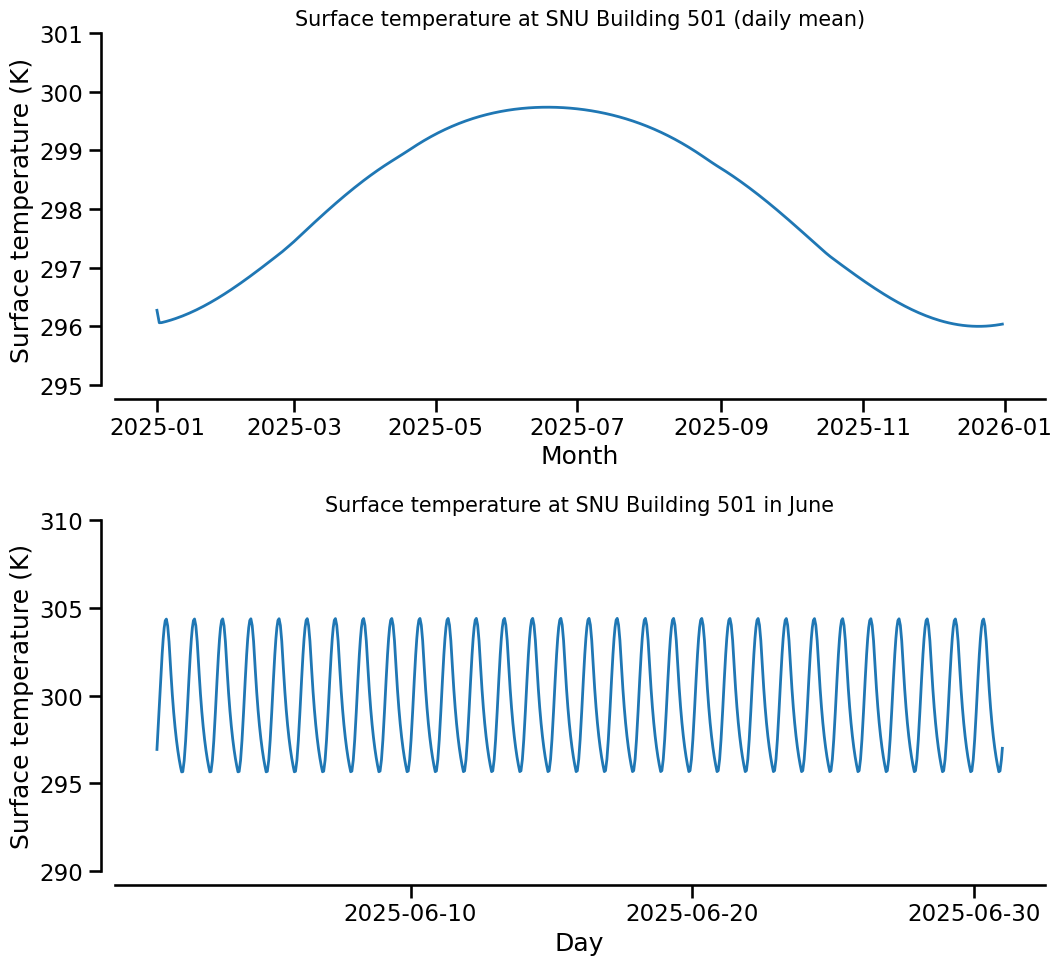

In [9]:
# Plot

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

sns.set_context('talk')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 10))

### plotting for daily mean Ts
Ts_daily = Ts.resample(time='1D').mean().isel(time=slice(0, 365))
ax[0].plot(Ts_daily.time, Ts_daily, linewidth=2)

### properties
ax[0].set_title('Surface temperature at SNU Building 501 (daily mean)', fontsize=15)
ax[0].set_xlabel('Month', fontsize=18)
ax[0].set_ylabel('Surface temperature (K)', fontsize=18)
ax[0].set_ylim(295, 301)


### plotting for Ts in June
Ts_june = Ts.sel(time=slice('2025-06-01', '2025-06-30'))
ax[1].plot(Ts_june.time, Ts_june, linewidth=2)

### properties
ax[1].set_title('Surface temperature at SNU Building 501 in June', fontsize=15)
ax[1].set_xlabel('Day', fontsize=18)
ax[1].xaxis.set_major_locator(mdates.DayLocator(bymonthday=[10, 20, 30]))
ax[1].set_ylabel('Surface temperature (K)', fontsize=18)
ax[1].set_ylim(290, 310)
ax[1].set_yticks([290, 295, 300, 305, 310])



sns.despine(offset=10)
plt.tight_layout()